In [73]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
from pylab import *
import researchpy as rp
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

# Домашняя работа №5.

* Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

In [36]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


Данный датасет разобран в начале лекции 5.

Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр максимально влияет на болезнь.

Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.
Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима). Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [28]:
data.shape

(70000, 13)

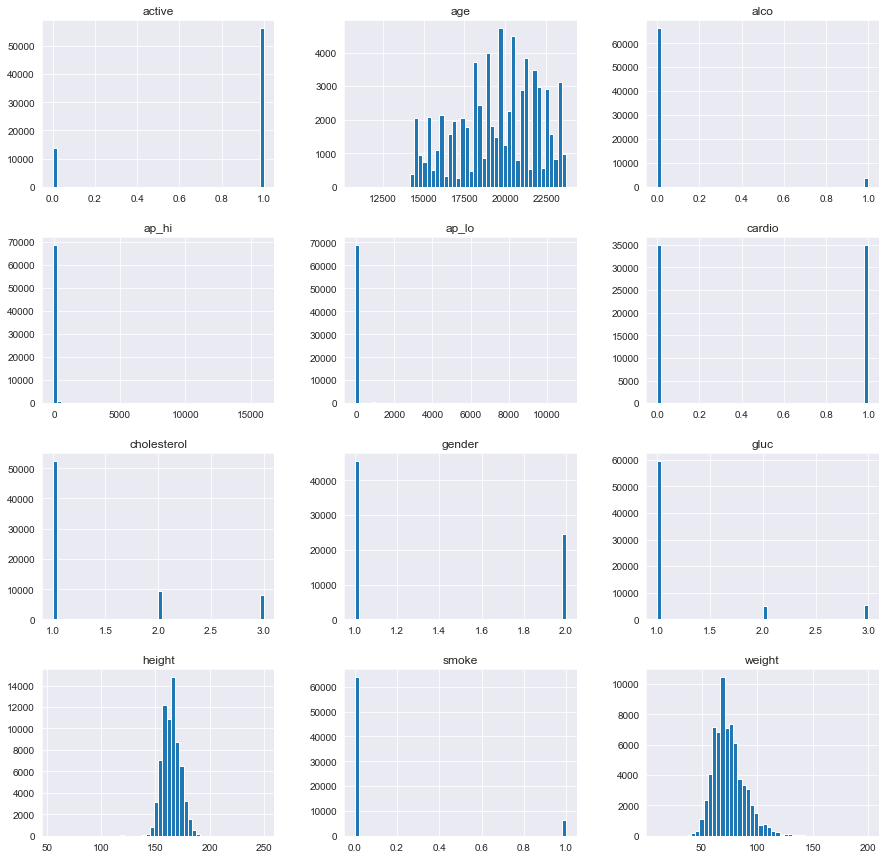

In [29]:
#Построим частотные графики для всех атрибутов, кроме id
data.iloc[:,1:].hist(figsize=(15,15), bins=50)
plt.show()

In [ ]:
# По графику можно понять, что в атрибтах ap_hi, ap_lo есть выбросы (неадекватно завышенные значения)

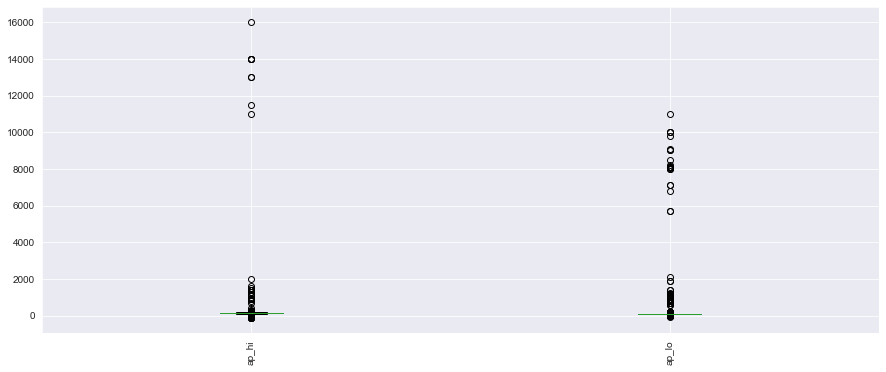

In [37]:
# В графике boxplot наглядно видны выбросы (давление не может измерятся в тысячах и не может быть отрицательным)
boxplot = data[['ap_hi','ap_lo']].boxplot(figsize=(15,6), rot=90)

In [38]:
# Выбираем только значения в промежутке от 60 до 300, остальные будут NaN
data['ap_hi'] = data['ap_hi'][(data['ap_hi']>60) & (data['ap_hi']<300)]
data['ap_lo'] = data['ap_lo'][(data['ap_lo']>60) & (data['ap_lo']<300)]

In [42]:
# Удаляем NaN значения
data.dropna(subset=['ap_hi', 'ap_lo'], inplace=True)

In [43]:
data.shape

(65944, 13)

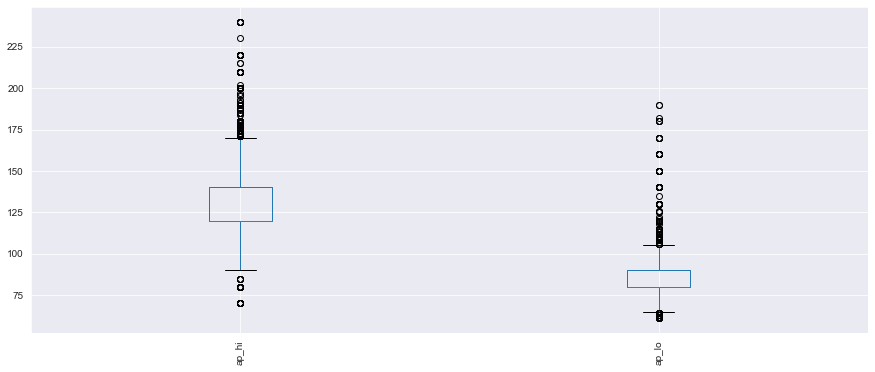

In [48]:
# В графике boxplot выбросы остаются, но такие показатели давления могут быть реальными, поэтому их осталяем
boxplot = data[['ap_hi','ap_lo']].boxplot(figsize=(15,6), rot=90)

In [58]:
input_x = data.iloc[:,1:-1] # Все поля кроме id и cardio
output_y = data['cardio'] # Только поле cardio

In [59]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
Y=le.fit_transform(output_y)

In [60]:
# Разделим на 70% тренировочных и на 30% тестовых
from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.3)

In [61]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
from sklearn.metrics import classification_report

model_pred = model.predict(X_test_22)

print(classification_report(y_test_22, model_pred))

model.score(X_test_22, y_test_22)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      9831
           1       0.72      0.69      0.71      9953

    accuracy                           0.71     19784
   macro avg       0.71      0.71      0.71     19784
weighted avg       0.71      0.71      0.71     19784



0.7090578245046503

In [ ]:
# Модель "рандомных деревьев" дала точность предсказания 71%.

No handles with labels found to put in legend.


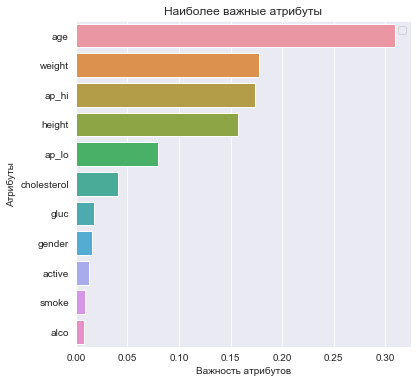

In [64]:
headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [ ]:
# Наиболее важный атрибут это возраст

In [71]:
# Проверим с помощью ttest гипотезу о том, что возраст влияет на здоровье
data_healthy = data[data['cardio']==0].age
data_ill = data[data['cardio']==1].age

In [74]:
descriptives, results = rp.ttest(data_healthy, data_ill)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N          Mean           SD         SE     95% Conf.  \
0       age  32606.0  18928.767589  2465.382056  13.653232  18902.006752   
1       age  33338.0  20066.875127  2312.358135  12.664421  20042.052418   
2  combined  65944.0  19504.138041  2456.053166   9.564232  19485.392146   

       Interval  
0  18955.528425  
1  20091.697837  
2  19522.883936  
_____________________________
          Independent t-test     results
0  Difference (age - age) =   -1138.1075
1      Degrees of freedom =   65942.0000
2                       t =     -61.1580
3   Two side test p value =       0.0000
4  Difference < 0 p value =       0.0000
5  Difference > 0 p value =       1.0000
6               Cohen's d =      -0.4763
7               Hedge's g =      -0.4763
8           Glass's delta =      -0.4616
9                       r =       0.2317


In [ ]:
# p value = 0, это значит, что выборки здоровый и больных людей по возрасту статистически различаются, 
# при этом количество здоровых и больных людей приблизительно одинакова.
# Средний возраст здоровых людей 18928 дней, а больных 20066, т.е. здоровые люди более молодные